In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [7]:
data = pd.read_csv("input/data-attendance-1.txt")
data.head()

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


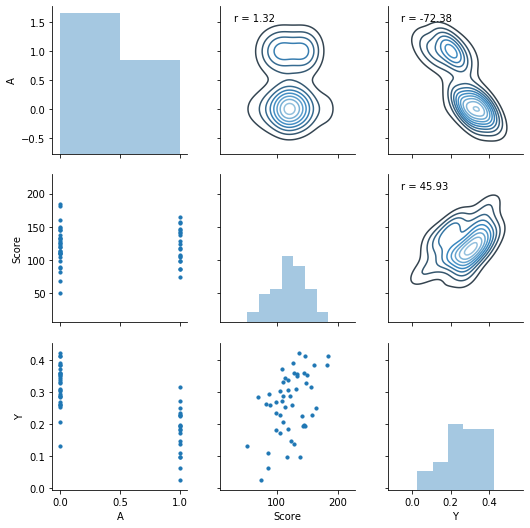

In [8]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r*100),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.PairGrid(data, palette=["red"])
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_upper(corrfunc)

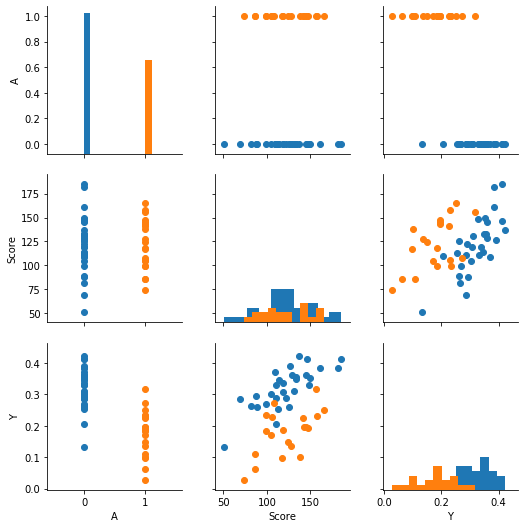

In [9]:
g = sns.PairGrid(data, hue="A")
g = g.map_upper(plt.scatter)
g = g.map_diag(plt.hist)
g = g.map_lower(plt.scatter)

$$\mu_i = b_1 + b_2 * A_i + b_3 * Score_i$$
$$Y_i \sim Normal(\mu_i, \sigma)$$

In [10]:
def model(a, score, y):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    b3 = pyro.sample("b3", dist.Normal(0, 100))
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 2.7))
    mu = b1 + b2 * a + b3 * score
    with pyro.plate("data", len(y)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [11]:
a = torch.tensor(data.A).float()
score = torch.tensor(data.Score).float() / 200
y = torch.tensor(data.Y).float()

In [12]:
nuts_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(nuts_kernel, num_chains=4, num_samples=1000, warmup_steps=1000).run(a, score, y)

In [13]:
sites = ["b1","b2","b3","sigma"]
d_mcmc = EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0].detach().cpu().reshape(-1, len(sites)).numpy()

In [14]:
df_mcmc = pd.DataFrame(d_mcmc)
df_mcmc.columns = sites
df_mcmc_quantile = df_mcmc.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
df_mcmc_quantile

,0.025,0.25,0.5,0.75,0.975
b1,0.056531,0.101552,0.122308,0.143493,0.184268
b2,-0.173351,-0.153778,-0.143865,-0.134919,-0.114525
b3,0.228891,0.292874,0.325655,0.359893,0.428532
sigma,0.042684,0.047802,0.051233,0.055140,0.064460


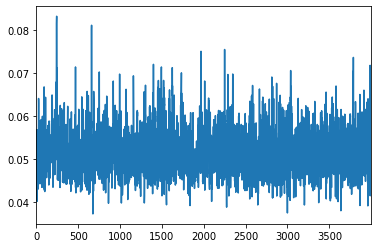

In [15]:
df_mcmc.sigma.plot()

In [16]:
df_mcmc.mean(axis=0) #EAP

b1       0.122351
b2      -0.144131
b3       0.326703
sigma    0.051816
dtype: float32

$$\mu_i = 0.124 - 0.144 * A_i + 0.324 * Score_i$$
$$Y_i \sim Normal(\mu_i, 0.052)$$

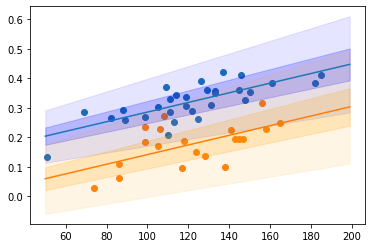

In [17]:
fig = plt.figure()
plt.scatter(data[data.A==0].Score, data[data.A==0].Y)
plt.scatter(data[data.A==1].Score, data[data.A==1].Y)
plt.plot(range(50, 200), df_mcmc.mean(axis=0).b1 + df_mcmc.mean(axis=0).b2 * 0 + df_mcmc.mean(axis=0).b3 * range(50, 200)/200)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.025].loc["b1"] + df_mcmc_quantile[0.025].loc["b2"] * 0 + df_mcmc_quantile[0.025].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.975].loc["b1"] + df_mcmc_quantile[0.975].loc["b2"] * 0 + df_mcmc_quantile[0.975].loc["b3"] * range(50, 200)/200, color='b', alpha=0.1)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.25].loc["b1"] + df_mcmc_quantile[0.25].loc["b2"] * 0 + df_mcmc_quantile[0.25].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.75].loc["b1"] + df_mcmc_quantile[0.75].loc["b2"] * 0 + df_mcmc_quantile[0.75].loc["b3"] * range(50, 200)/200, color='b', alpha=0.2)

plt.plot(range(50, 200), df_mcmc.mean(axis=0).b1 + df_mcmc.mean(axis=0).b2 * 1 + df_mcmc.mean(axis=0).b3 * range(50, 200)/200)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.025].loc["b1"] + df_mcmc_quantile[0.025].loc["b2"] * 1 + df_mcmc_quantile[0.025].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.975].loc["b1"] + df_mcmc_quantile[0.975].loc["b2"] * 1 + df_mcmc_quantile[0.975].loc["b3"] * range(50, 200)/200, color='orange', alpha=0.1)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.25].loc["b1"] + df_mcmc_quantile[0.25].loc["b2"] * 1 + df_mcmc_quantile[0.25].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.75].loc["b1"] + df_mcmc_quantile[0.75].loc["b2"] * 1 + df_mcmc_quantile[0.75].loc["b3"] * range(50, 200)/200, color='orange', alpha=0.2)

In [18]:
def predictive_model(a, score):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    b3 = pyro.sample("b3", dist.Normal(0, 100))
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 2.7))
    mu = b1 + b2 * a + b3 * score
    return pyro.sample("y", dist.Normal(mu, sigma))

In [19]:
predictive_distribution = TracePredictive(predictive_model, mcmc_posterior, num_samples=1000)

In [20]:
predict_result = EmpiricalMarginal(predictive_distribution.run(a, score), "y")._get_samples_and_weights()[0]

KeyError: 'data'

NameError: name 'predict_result' is not defined

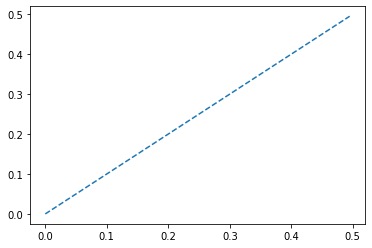

In [21]:
fig = plt.figure()
plt.plot(torch.arange(0, 100).numpy() / 200,torch.arange(0, 100).numpy() / 200, '--')
plt.scatter(data.Y, predict_result.mean(0).numpy())


In [22]:
kde = sm.nonparametric.KDEUnivariate(df_mcmc.sigma.values.astype("float64"))
kde.fit()
sigma_map = kde.support[np.argmax(kde.density)]

NameError: name 'sm' is not defined

In [23]:
mus = (df_mcmc.b1.values.reshape(-1, 1) + np.dot(df_mcmc.b2.values.reshape(-1, 1), data.A.values.reshape(1, -1)) + np.dot(df_mcmc.b3.values.reshape(-1, 1), data.Score.values.reshape(1, -1)/200)).T

In [24]:
x = np.arange(-0.2, 0.2, 0.1/100)
y = stats.norm.pdf(x, loc=0, scale=sigma_map)
plt.plot(x, y, '--')
sns.distplot(data.Y.values - mus.mean(1))

NameError: name 'sigma_map' is not defined